# Generalized Linear Mixed‐effects Model Playground

or the many ways to perform GLMM in python  
  
A comparison among:  
[StatsModels](https://github.com/statsmodels/statsmodels)  
[Theano](https://github.com/Theano/Theano)  
[PyMC3](https://github.com/pymc-devs/pymc3)(Base on Theano)  
[TensorFlow](https://github.com/tensorflow/tensorflow)  
[Stan](https://github.com/stan-dev/stan) and [pyStan](https://github.com/stan-dev/pystan)  
[Keras](https://github.com/fchollet/keras) with Theano backend

In [1]:
import numpy as np
#import pandas as pd
import seaborn as sns
from theano import tensor as tt
%pylab inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux

Populating the interactive namespace from numpy and matplotlib


# Prepare data and quick visualization

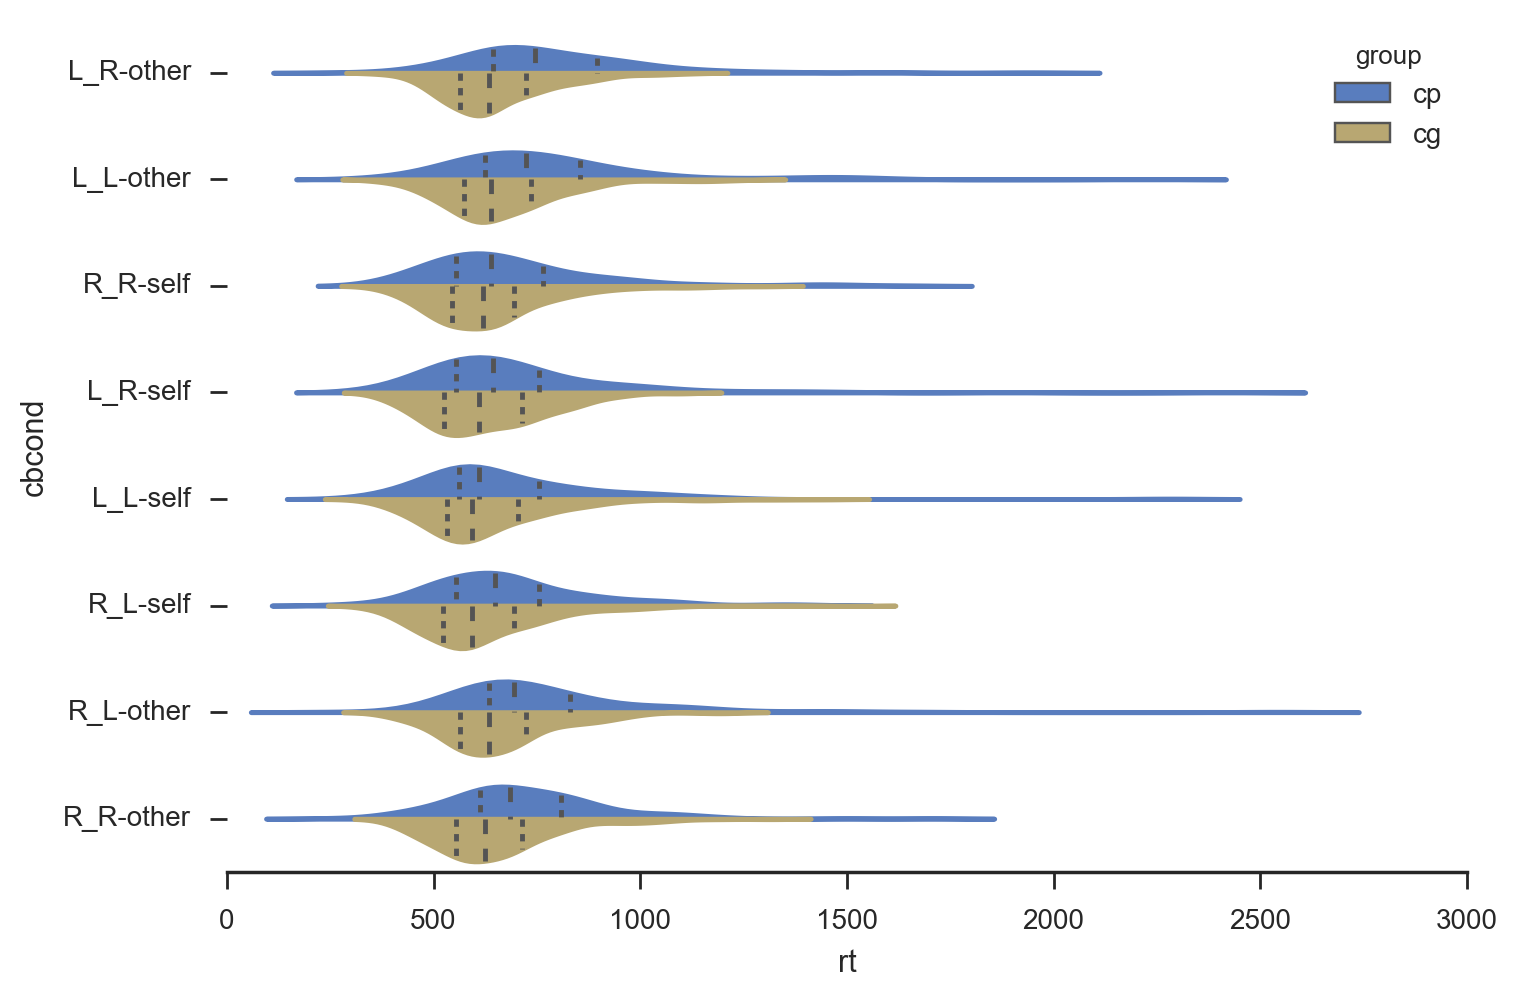

In [2]:
# load data
import pandas as pd
Tbl_beh  = pd.read_csv('./behavioral_data.txt', delimiter='\t')
Tbl_beh["subj"]  = Tbl_beh["subj"].astype('category')
#%% visualized data
# Draw a nested violinplot and split the violins for easier comparison
sns.set(style="ticks", palette="muted", color_codes=True)
plt.figure()
Tbl_beh['cbcond']  = pd.Series(Tbl_beh['chimera'] + '-' + Tbl_beh['identity'], index=Tbl_beh.index)
sns.violinplot(y="cbcond", x="rt", hue="group", data=Tbl_beh, split=True,
               inner="quart", palette={"cp": "b", "cg": "y"})
sns.despine(left=True)

`Tbl_beh` is the raw data table.  

In [3]:
Tbl_beh.head(5)

,subj,trial,chimera,identity,orientation,rt,acc,group,cbcond
0,1,1,L_R,other,upright,754.6,0,cp,L_R-other
1,1,2,L_L,other,upright,1036.1,1,cp,L_L-other
2,1,3,R_R,self,upright,433.0,1,cp,R_R-self
3,1,4,L_R,self,upright,463.4,1,cp,L_R-self
4,1,5,L_L,self,upright,483.3,1,cp,L_L-self


In [4]:
tbltmp  = Tbl_beh.copy(deep=True)
sizetbl = tbltmp.shape
tbltmp['trialcount']  = pd.Series(np.ones((sizetbl[0],),dtype=np.int8), index=tbltmp.index)

tbltmp.set_index(['subj', 'chimera','identity','orientation','group'], inplace=True)
tblmean = tbltmp.mean(level=[0,1,2,3,4])
tblmean = tblmean.reset_index()
tblmean["subj"] = tblmean["subj"].astype('category')
tblsum  = tbltmp.sum(level=[0,1,2,3,4])
tblsum  = tblsum.reset_index()
tblsum["subj"]  = tblsum["subj"].astype('category')

`tblmean` and `tblsum` is the summary data table.  

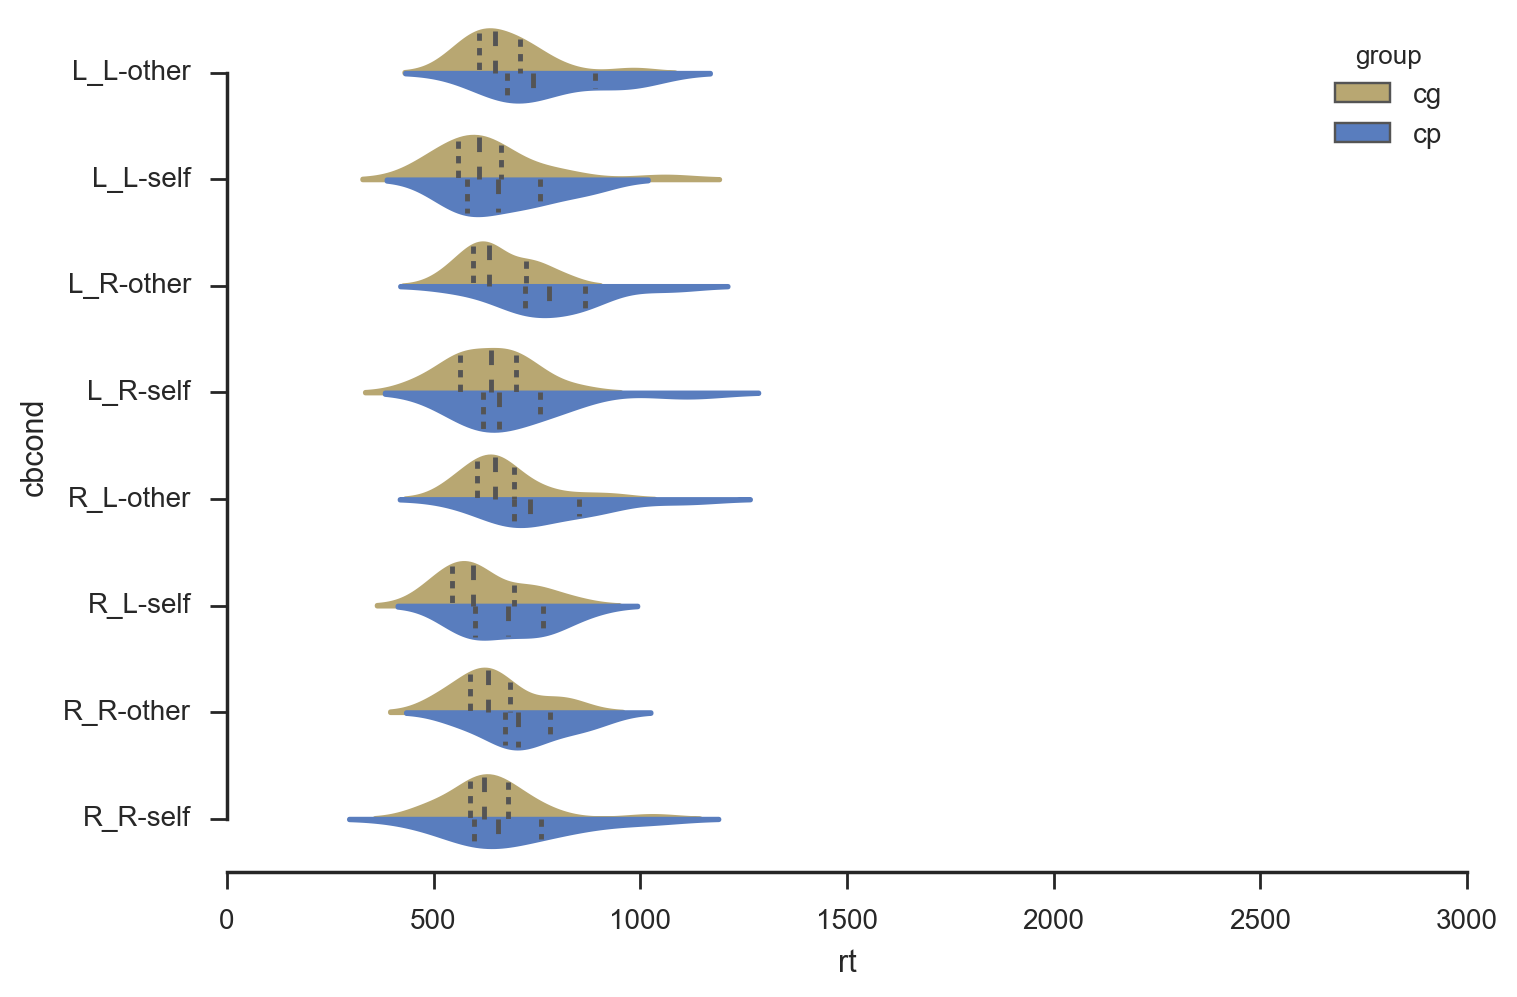

In [5]:
tblmean['cbcond']  = pd.Series(tblmean['chimera'] + '-' + tblmean['identity'], 
                index=tblmean.index)

## boxplot + scatter plot to show accuracy
#ax = sns.boxplot(y="cbcond", x="acc", data=tbltest,
#                 whis=np.inf, color="c")
## Add in points to show each observation
#sns.stripplot(y="cbcond", x="acc", data=tbltest,
#              jitter=True, size=3, color=".3", linewidth=0)
plt.figure()
g1 = sns.violinplot(y="cbcond", x="rt", hue="group", data=tblmean, split=True,
               inner="quart", palette={"cp": "b", "cg": "y"})
g1.set(xlim=(0, 3000))
# Make the quantitative axis logarithmic
sns.despine(trim=True)

In [6]:
tblsum.head(5)

,subj,chimera,identity,orientation,group,trial,rt,acc,trialcount
0,1,L_L,other,inverted,cg,NaN,NaN,NaN,NaN
1,1,L_L,other,inverted,cp,1278.0,7133.7,8.0,10.0
2,1,L_L,other,upright,cg,NaN,NaN,NaN,NaN
3,1,L_L,other,upright,cp,425.0,7495.5,8.0,10.0
4,1,L_L,self,inverted,cg,NaN,NaN,NaN,NaN


In [7]:
tbltest = Tbl_beh

# Using StatsModels to perform a linear mixed model of reaction time

In [8]:
import statsmodels.formula.api as smf
from patsy import dmatrices
formula = "rt ~ group*orientation*identity"
#formula = "rt ~ -1 + cbcond"
md  = smf.mixedlm(formula, tbltest, groups=tbltest["subj"])
mdf = md.fit()
print(mdf.summary())
#%% GLMM with pymc3 for reaction time data
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._params = np.zeros(self.k_tot)


                               Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               rt         
No. Observations:               3191                  Method:                           REML       
No. Groups:                     20                    Scale:                            25060.1757 
Min. group size:                155                   Likelihood:                       -20692.3545
Max. group size:                160                   Converged:                        Yes        
Mean group size:                159.6                                                              
---------------------------------------------------------------------------------------------------
                                                     Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

# Using PyMC3

In [ ]:
beta0     = np.linalg.lstsq(X,Y)

fixedpred = np.argmax(X,axis=1)
randmpred = np.argmax(Z,axis=1)

con  = tt.constant(fixedpred)
sbj  = tt.constant(randmpred)
import pymc3 as pm
with pm.Model() as glmm1:
    # Fixed effect
    beta = pm.Normal('beta', mu = 0, sd = 100, shape=(nfixed[1]))
    # random effect
    s    = pm.HalfCauchy('s',50,shape=(nrandm[1]))
    b    = pm.Normal('b', mu = 0, sd = s, shape=(nrandm[1]))
    eps  = pm.HalfCauchy('eps', 5)
    
    #mu_est = pm.Deterministic('mu_est',beta[con] + b[sbj])
    mu_est = pm.Deterministic('mu_est',tt.dot(X,beta)+tt.dot(Z,b))
    RT = pm.Normal('RT', mu_est, eps, observed = Y)
    
    # start = pm.find_MAP()
    # h = find_hessian(start)

with glmm1:
    # means, sds, elbos = pm.variational.advi(n=100000)
    trace = pm.sample(3000)
    
pm.traceplot(trace,varnames=['beta','b','s']) # 
plt.show()
burnin1 = 2000
df_summary = pm.df_summary(trace[burnin1:],varnames=['beta'])
df_summary.index=Terms
print(df_summary)

# Using Theano
This is a non-probabilistic model, but none-the-less uncertainty related to parameter estimation could be obtained using dropout (http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html).

In [10]:
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

X = X.astype(np.float32)
Z = Z.astype(np.float32)
Y = Y.astype(np.float32)

import theano
theano.config.compute_test_value = 'ignore'

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def model(X, beta, Z, b):
    return tt.sum(tt.dot(X, beta) + tt.dot(Z, b),axis=1)

def sgd(cost, params, lr=0.001):
    grads = tt.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates
    
Xtf   = tt.fmatrix()
Ztf   = tt.fmatrix()
y     = tt.vector()
tbeta = init_weights([nfixed[1], 1])
tb    = init_weights([nrandm[1], 1])
eps   = init_weights([0])
y_    = model(Xtf, tbeta, Ztf,tb)

cost    = tt.mean(tt.sqr(y - y_))
params  = [tbeta, tb]
updates = sgd(cost, params)

train = theano.function(inputs=[Xtf, Ztf, y], outputs=cost, updates=updates, allow_input_downcast=True)

for i in range(50000):
    sel = np.random.randint(0,nfixed[0],size=int(nfixed[0]/2))
    batch_xs, batch_zs, batch_ys = X[sel,:],Z[sel,:],Y[sel]    
    train(batch_xs, batch_zs, batch_ys)
        
outdf = pd.DataFrame(data=tbeta.get_value(),columns=['beta'],index=Terms)
print (outdf)

                                                          beta
Intercept                                           652.988618
group[T.cp]                                         160.204658
orientation[T.upright]                              -67.203497
identity[T.self]                                    -21.004131
group[T.cp]:orientation[T.upright]                  -77.994843
group[T.cp]:identity[T.self]                        -56.193032
orientation[T.upright]:identity[T.self]             -14.557108
group[T.cp]:orientation[T.upright]:identity[T.s...   19.592060


# Using TensorFlow

In [11]:
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y)
nfixed = np.shape(X)
nrandm = np.shape(Z)

X = X.astype(np.float32)
Z = Z.astype(np.float32)
Y = Y.astype(np.float32)

import tensorflow as tf
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, beta, Z, b):
    y_pred = tf.matmul(X, beta) + tf.matmul(Z, b)
    #randcoef = tf.matmul(Z, b)
    #Xnew     = tf.transpose(X) * tf.transpose(randcoef)
    #y_pred   = tf.matmul(tf.transpose(Xnew), beta)
    return y_pred # notice we use the same model as linear regression, 
                  # this is because there is a baked in cost function which performs softmax and cross entropy

Xtf   = tf.placeholder("float32", [None, nfixed[1]]) # create symbolic variables
Ztf   = tf.placeholder("float32", [None, nrandm[1]])
y     = tf.placeholder("float32", [None, 1])
beta  = init_weights([nfixed[1], 1])
b     = init_weights([nrandm[1], 1])
eps   = init_weights([0])
y_    = model(Xtf, beta, Ztf, b)
# y_    = tf.nn.softmax(model(Xtf, beta) + model(Ztf, b) + eps)

# cost  = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_), reduction_indices=[1]))
cost  = tf.square(y - y_) # use square error for cost function

train_step    = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

init          = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver         = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for i in range(5000):
        sel = np.random.randint(0,nfixed[0],size=int(nfixed[0]/2))
        batch_xs, batch_zs, batch_ys = X[sel,:],Z[sel,:],Y[sel]
        sess.run(train_step, feed_dict={Xtf: batch_xs, Ztf: batch_zs, y: batch_ys})
        
        accuracy = tf.reduce_mean(tf.cast(cost, tf.float32))
        if i % 1000 == 0:        
            print(i,sess.run(accuracy, feed_dict={Xtf: X, Ztf: Z, y: Y}))

    betaend = sess.run(beta)
    bend    = sess.run(b)
    
outdf2 = pd.DataFrame(data=betaend,columns=['beta'],index=Terms)
print (outdf2)

0 138542.0
1000 24859.4
2000 24867.4
3000 24865.0
4000 24859.4
                                                          beta
Intercept                                           652.001404
group[T.cp]                                         166.414017
orientation[T.upright]                              -65.417686
identity[T.self]                                    -18.327265
group[T.cp]:orientation[T.upright]                  -88.227432
group[T.cp]:identity[T.self]                        -65.559731
orientation[T.upright]:identity[T.self]             -21.836357
group[T.cp]:orientation[T.upright]:identity[T.s...   39.658234


# Display estimation

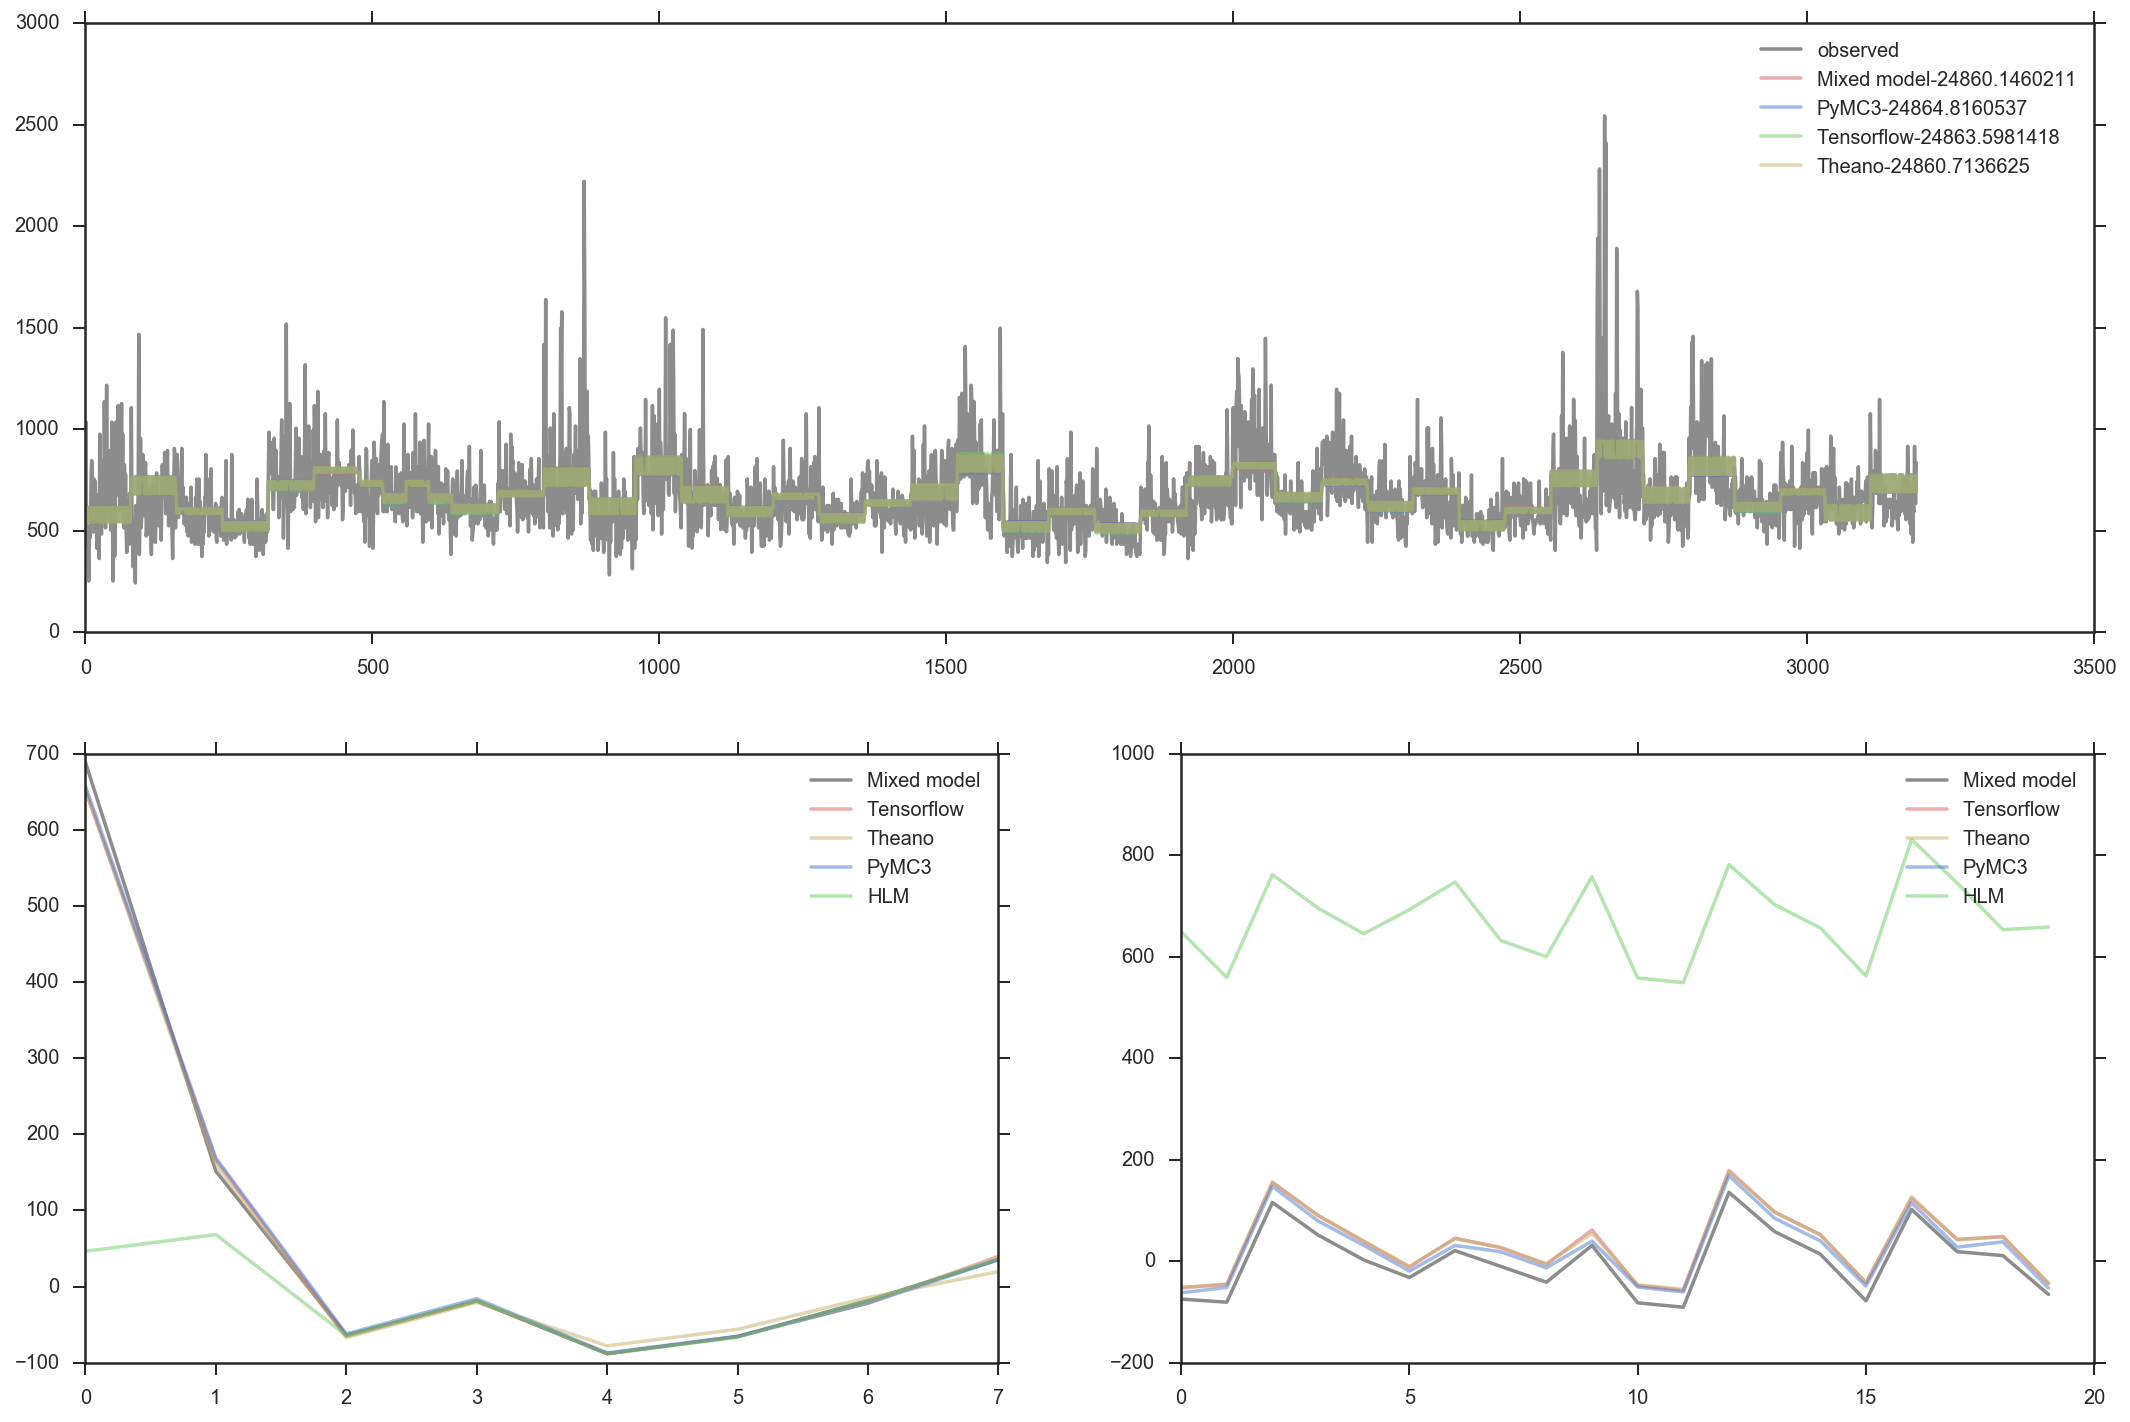

                                                           LMM       PyMC3  \
Intercept                                           689.061471  657.759756   
group[T.cp]                                         151.588892  168.839062   
orientation[T.upright]                              -64.126129  -62.172687   
identity[T.self]                                    -19.167092  -15.994162   
group[T.cp]:orientation[T.upright]                  -88.333875  -87.208586   
group[T.cp]:identity[T.self]                        -65.824576  -65.374701   
orientation[T.upright]:identity[T.self]             -18.434285  -21.924377   
group[T.cp]:orientation[T.upright]:identity[T.s...   35.327307   35.269983   

                                                    Tensorflow      Theano  
Intercept                                           652.001404  652.988618  
group[T.cp]                                         166.414017  160.204658  
orientation[T.upright]                              -65.417686  -6

In [12]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(18,12))
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0,0:2])
yd  = np.asarray(tbltest.rt)
ax1.plot(yd,'k',alpha = .5)

fitted=np.dot(X,mdf.fe_params)+np.dot(Z,mdf.random_effects).flatten()
ax1.plot(fitted,'r',alpha = .5)

df_summary1 = pm.df_summary(trace[burnin1:],varnames=['beta'])
betapymc = np.asarray(df_summary1['mean'])
df_summary2 = pm.df_summary(trace[burnin1:],varnames=['b'])
bpymc = np.asarray(df_summary2['mean'])
fitted1=np.dot(X,betapymc).flatten()+np.dot(Z,bpymc).flatten()
ax1.plot(fitted1,'b',alpha = .5)

fitted2=np.dot(X,betaend).flatten()+np.dot(Z,bend).flatten()
ax1.plot(fitted2,'g',alpha = .5)

fitted3=np.dot(X,tbeta.get_value()).flatten()+np.dot(Z,tb.get_value()).flatten()
ax1.plot(fitted3,'y',alpha = .5)

ax1.legend(['observed',
            'Mixed model'+'-'+str(np.mean(np.square(yd-fitted))),
            'PyMC3'+'-'+str(np.mean(np.square(yd-fitted1))),
            'Tensorflow'+'-'+str(np.mean(np.square(yd-fitted2))),
            'Theano'+'-'+str(np.mean(np.square(yd-fitted3)))])
# plt.legend(['observed','Mixed model','PyMC3','Tensorflow'])

fixedCoef = pd.DataFrame(mdf.fe_params,columns=['LMM'])
fixedCoef['PyMC3']  = pd.Series(betapymc, index=fixedCoef.index)
fixedCoef['Tensorflow']  = pd.Series(betaend.flatten(), index=fixedCoef.index)
fixedCoef['Theano']  = pd.Series(tbeta.get_value().flatten(), index=fixedCoef.index)

fixed=np.asarray(mdf.fe_params).flatten()

ax2 = plt.subplot(gs[1,0])
ax2.plot(fixed,'k',alpha = .5)
ax2.plot(betaend,'r',alpha = .5)
ax2.plot(tbeta.get_value(),'y',alpha = .5)
ax2.plot(betapymc,'b',alpha = .5)

ydcnt  = np.copy(yd)
sbjidx = np.argmax(Z,axis=1)
b      = np.zeros(np.shape(np.unique(sbjidx)))
for i in np.unique(sbjidx):
    b[i] = np.mean(ydcnt[sbjidx == i])
    ydcnt[sbjidx == i] += -b[i]
beta1  = np.linalg.lstsq(X,ydcnt)
ax2.plot(beta1[0],'g',alpha = .5)

Xstack    = np.hstack((X,Z))
betastack = np.linalg.lstsq(Xstack,yd)
beta1s    = betastack[0]
ax2.legend(['Mixed model','Tensorflow','Theano','PyMC3','HLM'])

ax3 = plt.subplot(gs[1,1])
fixed=np.asarray(mdf.random_effects).flatten()
ax3.plot(fixed,'k',alpha = .5)
ax3.plot(bend,'r',alpha = .5)
ax3.plot(tb.get_value(),'y',alpha = .5)
ax3.plot(bpymc,'b',alpha = .5)
ax3.plot(b,'g',alpha = .5)
ax3.legend(['Mixed model','Tensorflow','Theano','PyMC3','HLM'])

plt.show()
print(fixedCoef)

# PyMC3 again 
model similar to brms

Applied log-transform to s and added transformed s_log to model.
Applied log-transform to sigma and added transformed sigma_log to model.
 [-----------------100%-----------------] 100000 of 100000 complete in 90.3 sec

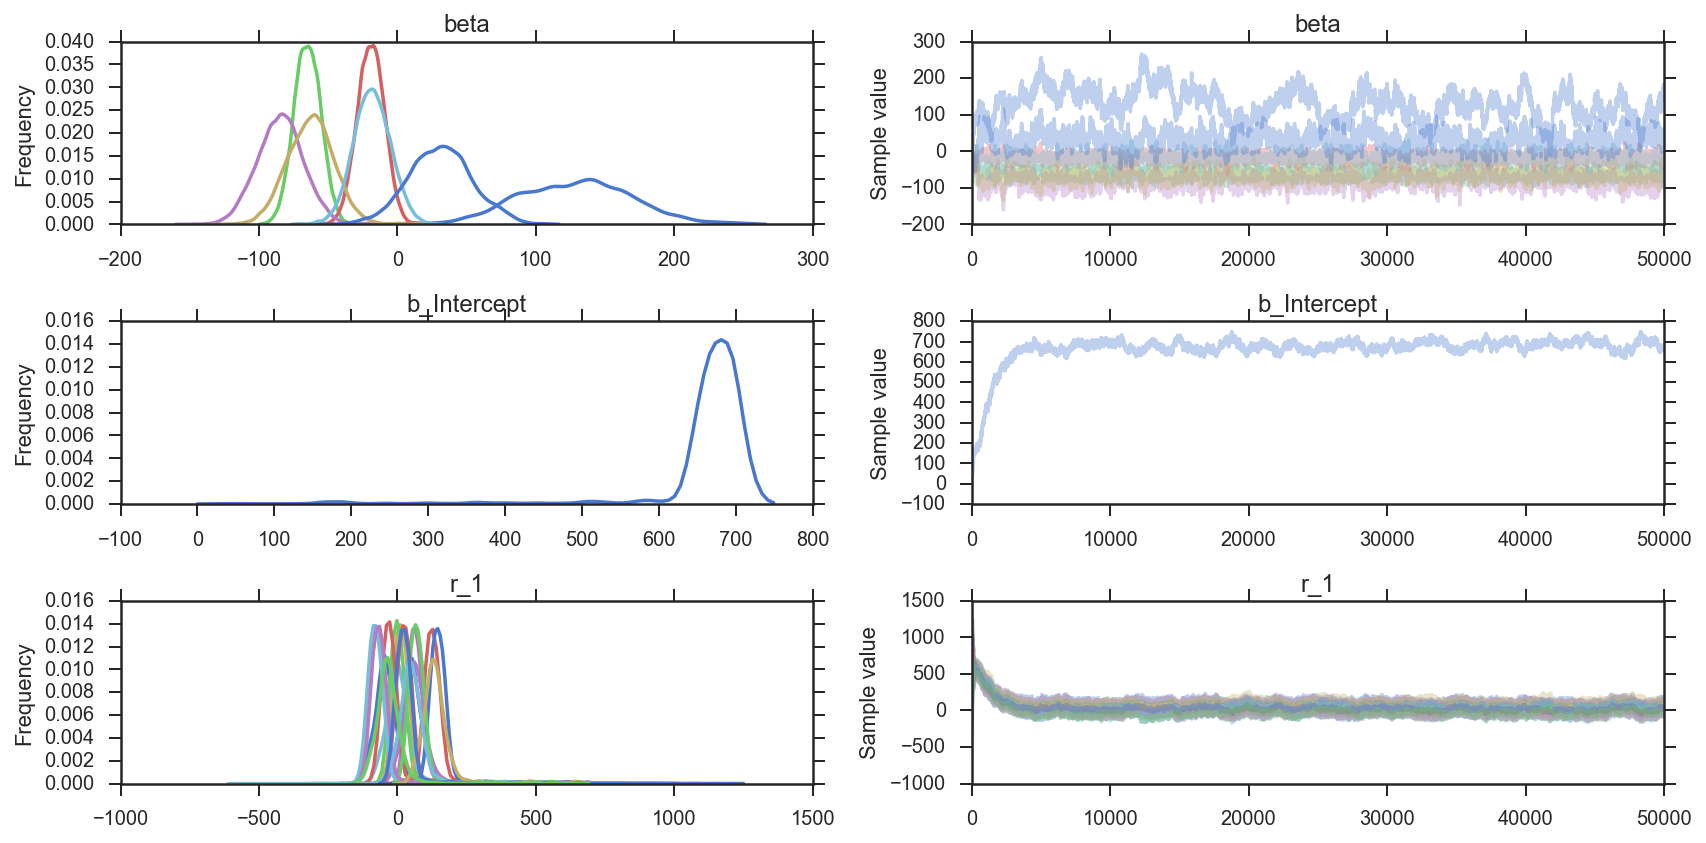

In [13]:
Y, X   = dmatrices(formula, data=tbltest, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices('rt ~ -1+subj', data=tbltest, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)
beta0     = np.linalg.lstsq(X,Y)

fixedpred = np.argmax(X,axis=1)
randmpred = np.argmax(Z,axis=1)

con  = tt.constant(fixedpred)
sbj  = tt.constant(randmpred)
import pymc3 as pm

X1     = X[0:,1:]
X_mean = np.mean(X1,axis=0) # column means of X before centering 
X_cent = X1 - X_mean

with pm.Model() as glmm2:
    # Fixed effect
    beta = pm.Normal('beta', mu = 0, sd = 100, shape=(nfixed[1]-1))
    
    # temporary Intercept 
    #temp_Intercept = pm.Flat('temp_Intercept')
    temp_Intercept = pm.Normal('temp_Intercept', mu = 0, sd = 100)
                               
    # random effect
    # group-specific standard deviation
    s      = pm.HalfCauchy('s', 5)#pm.StudentT('s',nu=3, mu=0, sd=186)#
    b      = pm.Normal('b', mu = 0, sd = 1, shape=(nrandm[1]))
    r_1    = pm.Deterministic('r_1',s*b)
    sigma  = pm.HalfCauchy('sigma', 5)#pm.StudentT('eps',nu=3, mu=0, sd=186)#
    
    # compute linear predictor 
    mu_est = tt.dot(X_cent,beta) + temp_Intercept + r_1[sbj]
    
    RT = pm.Normal('RT', mu_est, sigma, observed = Y)
    b_Intercept = pm.Deterministic("b_Intercept", temp_Intercept - tt.sum(X_mean * beta))
    # start = pm.find_MAP()
    # h = find_hessian(start)
    
with glmm2:
    # means, sds, elbos = pm.variational.advi(n=100000)
    trace2 = pm.sample(100000,step=pm.Metropolis())

    # start  = pm.find_MAP()
    # start['beta'] = beta0[0][1:]
    # step   = pm.NUTS(scaling=start)
    # trace2 = pm.sample(3000, step=pm.NUTS())

pm.traceplot(trace2[0::2],varnames=['beta','b_Intercept','r_1']) # 
plt.show()

In [14]:
burnin2    = 20000
df_summary = pm.df_summary(trace2[burnin2::2],varnames=['beta'])
df_stmp    = pm.df_summary(trace2[burnin2::2],varnames=['b_Intercept']) #['temp_Intercept']
df_new     = df_stmp.append(df_summary, ignore_index=True)

df_new.index=Terms
print(df_new)

                                                          mean         sd  \
Intercept                                           680.084857  21.933002   
group[T.cp]                                         125.094288  40.863710   
orientation[T.upright]                              -65.389661   9.546875   
identity[T.self]                                    -19.644194   9.783269   
group[T.cp]:orientation[T.upright]                  -84.003601  15.929138   
group[T.cp]:identity[T.self]                        -61.809227  16.491424   
orientation[T.upright]:identity[T.self]             -17.607791  13.435085   
group[T.cp]:orientation[T.upright]:identity[T.s...   30.151871  22.510208   

                                                    mc_error     hpd_2.5  \
Intercept                                           1.876938  637.922523   
group[T.cp]                                         3.690346   47.561655   
orientation[T.upright]                              0.413242  -84.272868   
id

# Usint PyStan (Model is constructed using brm in R)  


```r
library(lme4)
library(brms)
```
```
Tbl_beh <- read.csv("behavioral_data.txt",sep = "\t")
Tbl_beh$subj <- factor(Tbl_beh$subj)
Tbl_beh$trial <- factor(Tbl_beh$trial)
stanmodel <- make_stancode(rt ~ group*orientation*identity + (1|subj),
                data = Tbl_beh,family = "normal")
standata  <- make_standata(rt ~ group*orientation*identity + (1|subj),
                          data = Tbl_beh,family = "normal")
bayesfit <- brm(rt ~ group*orientation*identity + (1|subj),
                data = Tbl_beh,family = "normal")
bayesfit$model
summary(bayesfit, waic = TRUE)
```
```
lmefit <- lmer(rt ~ group*orientation*identity + (1|subj),
                 data = Tbl_beh)
summary(lmefit)
```

In [15]:
stan_datadict = {}
stan_datadict['N'] = Y.shape[0]
stan_datadict['Y'] = Y
stan_datadict['K'] = X1.shape[1]
stan_datadict['X'] = X_cent
stan_datadict['X_means'] = X_mean

stan_datadict['J_1'] = randmpred + 1
stan_datadict['N_1'] = max(randmpred + 1)
stan_datadict['K_1'] = 1
stan_datadict['Z_1'] = np.ones(randmpred.shape)

stan_datadict['prior_only'] = 0
#stan_datadict.items()

In [16]:
stan_mdlspec_lmm = """
    // This Stan code was generated with the R package 'brms'. 
    // We recommend generating the data with the 'make_standata' function. 
    functions { 
    } 
    data { 
      int<lower=1> N;  // total number of observations 
      vector[N] Y;  // response variable 
      int<lower=1> K;  // number of population-level effects 
      matrix[N, K] X;  // centered population-level design matrix 
      vector[K] X_means;  // column means of X before centering 
      // data for group-specific effects of subj 
      int<lower=1> J_1[N]; 
      int<lower=1> N_1; 
      int<lower=1> K_1; 
      vector[N] Z_1; 
      int prior_only;  // should the likelihood be ignored? 
    } 
    transformed data { 
    } 
    parameters { 
      vector[K] b;  // population-level effects 
      real temp_Intercept;  // temporary Intercept 
      real<lower=0> sd_1;  // group-specific standard deviation 
      vector[N_1] z_1;  // unscaled group-specific effects 
      real<lower=0> sigma;  // residual SD 
    } 
    transformed parameters { 
      // group-specific effects 
      vector[N_1] r_1; 
      vector[N] eta;  // linear predictor 
      r_1 <- sd_1 * (z_1);
      // compute linear predictor 
      eta <- X * b + temp_Intercept; 
      for (n in 1:N) { 
        eta[n] <- eta[n] + r_1[J_1[n]] * Z_1[n]; 
      } 
    } 
    model { 
      // prior specifications 
      sd_1 ~ student_t(3, 0, 186); 
      z_1 ~ normal(0, 1); 
      sigma ~ student_t(3, 0, 186); 
      // likelihood contribution 
      if (!prior_only) { 
        Y ~ normal(eta, sigma); 
      } 
    } 
    generated quantities { 
      real b_Intercept;  // population-level intercept 
      b_Intercept <- temp_Intercept - dot_product(X_means, b); 
    } 
    """

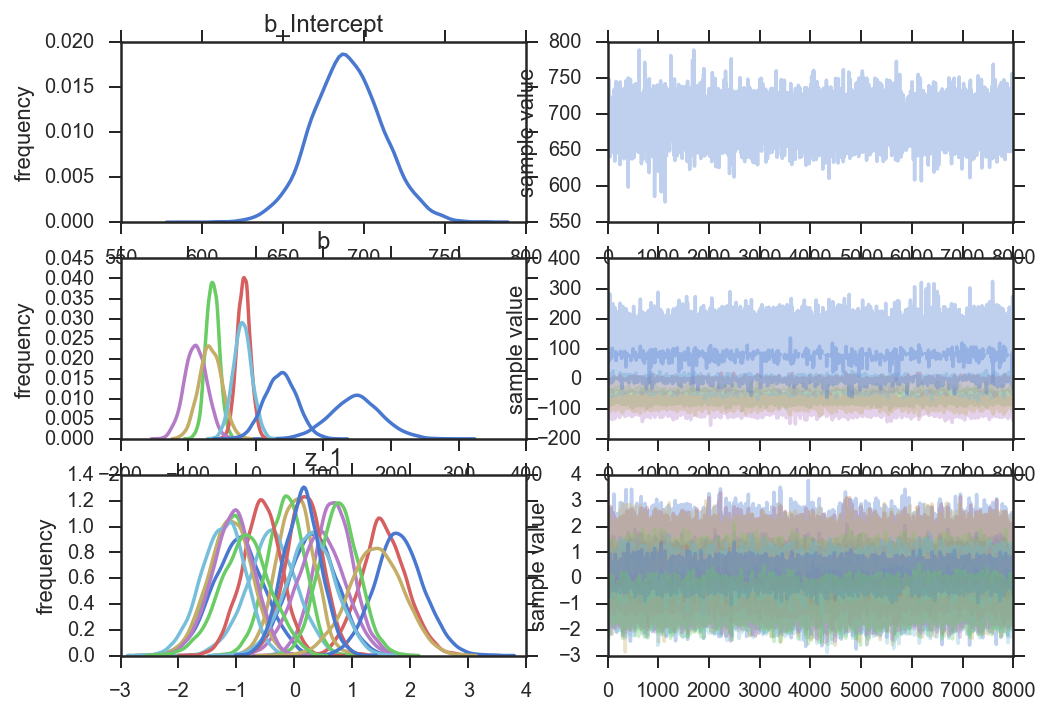

In [17]:
import pystan
stan_fit_lmm = pystan.stan(model_code=stan_mdlspec_lmm, data=stan_datadict,
                           iter=3000, warmup=1000, chains=4, n_jobs=2,verbose=False)
stan_fit_lmm.plot(pars=['b_Intercept','b','z_1'])
plt.show()

In [18]:
Itercept = stan_fit_lmm.extract(permuted=True)['b_Intercept']
betatemp = stan_fit_lmm.extract(permuted=True)['b']
btemp    = stan_fit_lmm.extract(permuted=True)['z_1']
sdtemp   = stan_fit_lmm.extract(permuted=True)['sd_1']
betastan = np.hstack([Itercept.mean(axis=0),betatemp.mean(axis=0)])
bstan    = btemp.mean(axis=0)*sdtemp.mean(axis=0)

                                                           LMM        Stan  \
Intercept                                           689.061471  689.825820   
group[T.cp]                                         151.588892  148.261003   
orientation[T.upright]                              -64.126129  -64.015505   
identity[T.self]                                    -19.167092  -17.970492   
group[T.cp]:orientation[T.upright]                  -88.333875  -88.844135   
group[T.cp]:identity[T.self]                        -65.824576  -66.990259   
orientation[T.upright]:identity[T.self]             -18.434285  -19.714631   
group[T.cp]:orientation[T.upright]:identity[T.s...   35.327307   37.047485   

                                                         PyMC2       PyMC1  \
Intercept                                           680.084857  657.759756   
group[T.cp]                                         125.094288  168.839062   
orientation[T.upright]                              -65.389661 

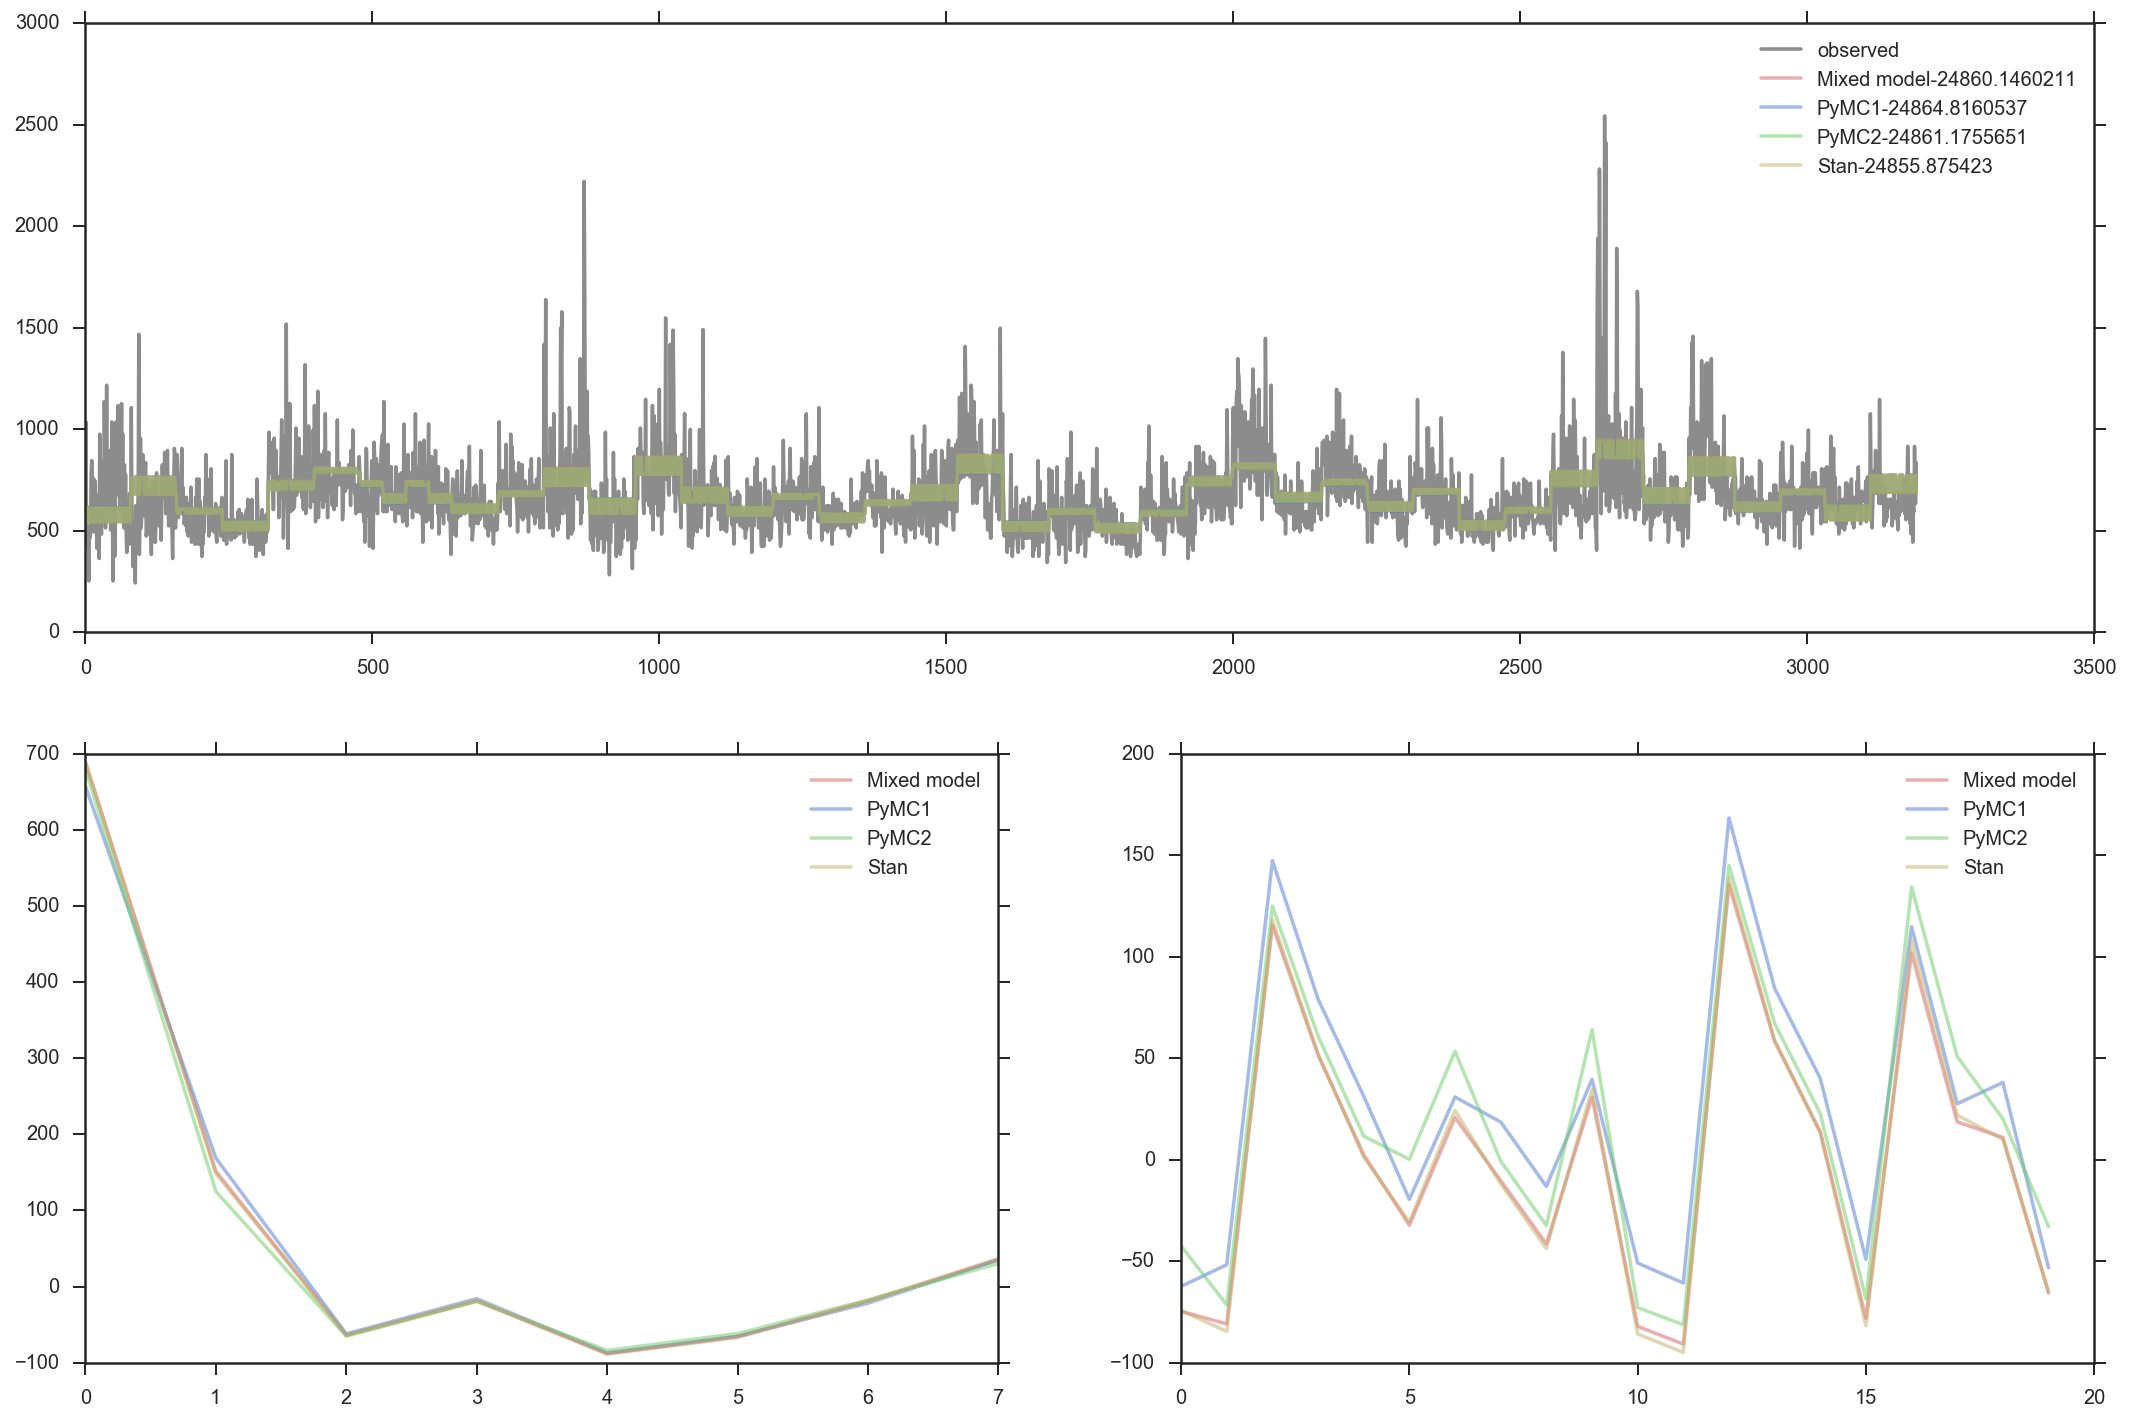

In [19]:
plt.figure(figsize=(18,12))

ax1 = plt.subplot(gs[0,0:2])
yd = np.asarray(tbltest.rt)
ax1.plot(yd,'k',alpha = .5)

fitted=np.dot(X,mdf.fe_params)+np.dot(Z,mdf.random_effects).flatten()
ax1.plot(fitted,'r',alpha = .5)

df_summary1 = pm.df_summary(trace[burnin1:],varnames=['beta'])
betapymc = np.asarray(df_summary1['mean'])
df_summary2 = pm.df_summary(trace[burnin1:],varnames=['b'])
bpymc = np.asarray(df_summary2['mean'])
fitted1=np.dot(X,betapymc).flatten()+np.dot(Z,bpymc).flatten()
ax1.plot(fitted1,'b',alpha = .5)

betapymc2 = np.asarray(df_new['mean'])
dftmp1 = pm.df_summary(trace2[burnin2::2],varnames=['r_1'])
bpymc2 = np.asarray(dftmp1['mean'])
fitted2=np.dot(X,betapymc2).flatten()+np.dot(Z,bpymc2).flatten()
ax1.plot(fitted2,'g',alpha = .5)

fittedstan=np.dot(X,betastan).flatten()+np.dot(Z,bstan).flatten()
ax1.plot(fittedstan,'y',alpha = .5)

ax1.legend(['observed',
            'Mixed model'+'-'+str(np.mean(np.square(yd-fitted))),
            'PyMC1'+'-'+str(np.mean(np.square(yd-fitted1))),
            'PyMC2'+'-'+str(np.mean(np.square(yd-fitted2))),
            'Stan'+'-'+str(np.mean(np.square(yd-fittedstan)))])

fixed=np.asarray(mdf.fe_params).flatten()
ax2 = plt.subplot(gs[1,0])
ax2.plot(fixed,'r',alpha = .5)
ax2.plot(betapymc,'b',alpha = .5)
ax2.plot(betapymc2,'g',alpha = .5)
ax2.plot(betastan,'y',alpha = .5)
ax2.legend(['Mixed model','PyMC1','PyMC2','Stan'])

ax3 = plt.subplot(gs[1,1])
randlmm=np.asarray(mdf.random_effects).flatten()
ax3.plot(randlmm,'r',alpha = .5)
ax3.plot(bpymc,'b',alpha = .5)
ax3.plot(bpymc2,'g',alpha = .5)
ax3.plot(bstan,'y',alpha = .5)
ax3.legend(['Mixed model','PyMC1','PyMC2','Stan'])

fixedCoef2 = pd.DataFrame(mdf.fe_params,columns=['LMM'])
fixedCoef2['Stan']  = pd.Series(betastan, index=fixedCoef2.index)
fixedCoef2['PyMC2']  = pd.Series(betapymc2, index=fixedCoef2.index)

fixedCoef2['PyMC1']  = pd.Series(betapymc, index=fixedCoef2.index)
fixedCoef2['Tensorflow']  = pd.Series(betaend.flatten(), index=fixedCoef2.index)
fixedCoef2['Theano']  = pd.Series(tbeta.get_value().flatten(), index=fixedCoef2.index)
print(fixedCoef2)

# Using Keras

In [20]:
from keras.models import Sequential
from keras.layers import Merge
from keras.layers.core import Dense

fixed_keras = Sequential()
fixed_keras.add(Dense(1, input_dim=X.shape[1]-1))

randm_keras = Sequential()
randm_keras.add(Dense(1, input_dim=Z.shape[1],bias=None))

merged = Merge([fixed_keras, randm_keras], mode='sum')

model = Sequential()
model.add(merged)

model.compile(loss='mean_squared_error', optimizer='sgd')

# train the model
model.fit([X[:,1:], Z], Y, nb_epoch=200, batch_size=100, verbose=0)

Using Theano backend.


                                                           LMM        Stan  \
Intercept                                           689.061471  689.825820   
group[T.cp]                                         151.588892  148.261003   
orientation[T.upright]                              -64.126129  -64.015505   
identity[T.self]                                    -19.167092  -17.970492   
group[T.cp]:orientation[T.upright]                  -88.333875  -88.844135   
group[T.cp]:identity[T.self]                        -65.824576  -66.990259   
orientation[T.upright]:identity[T.self]             -18.434285  -19.714631   
group[T.cp]:orientation[T.upright]:identity[T.s...   35.327307   37.047485   

                                                         PyMC2       PyMC1  \
Intercept                                           680.084857  657.759756   
group[T.cp]                                         125.094288  168.839062   
orientation[T.upright]                              -65.389661 

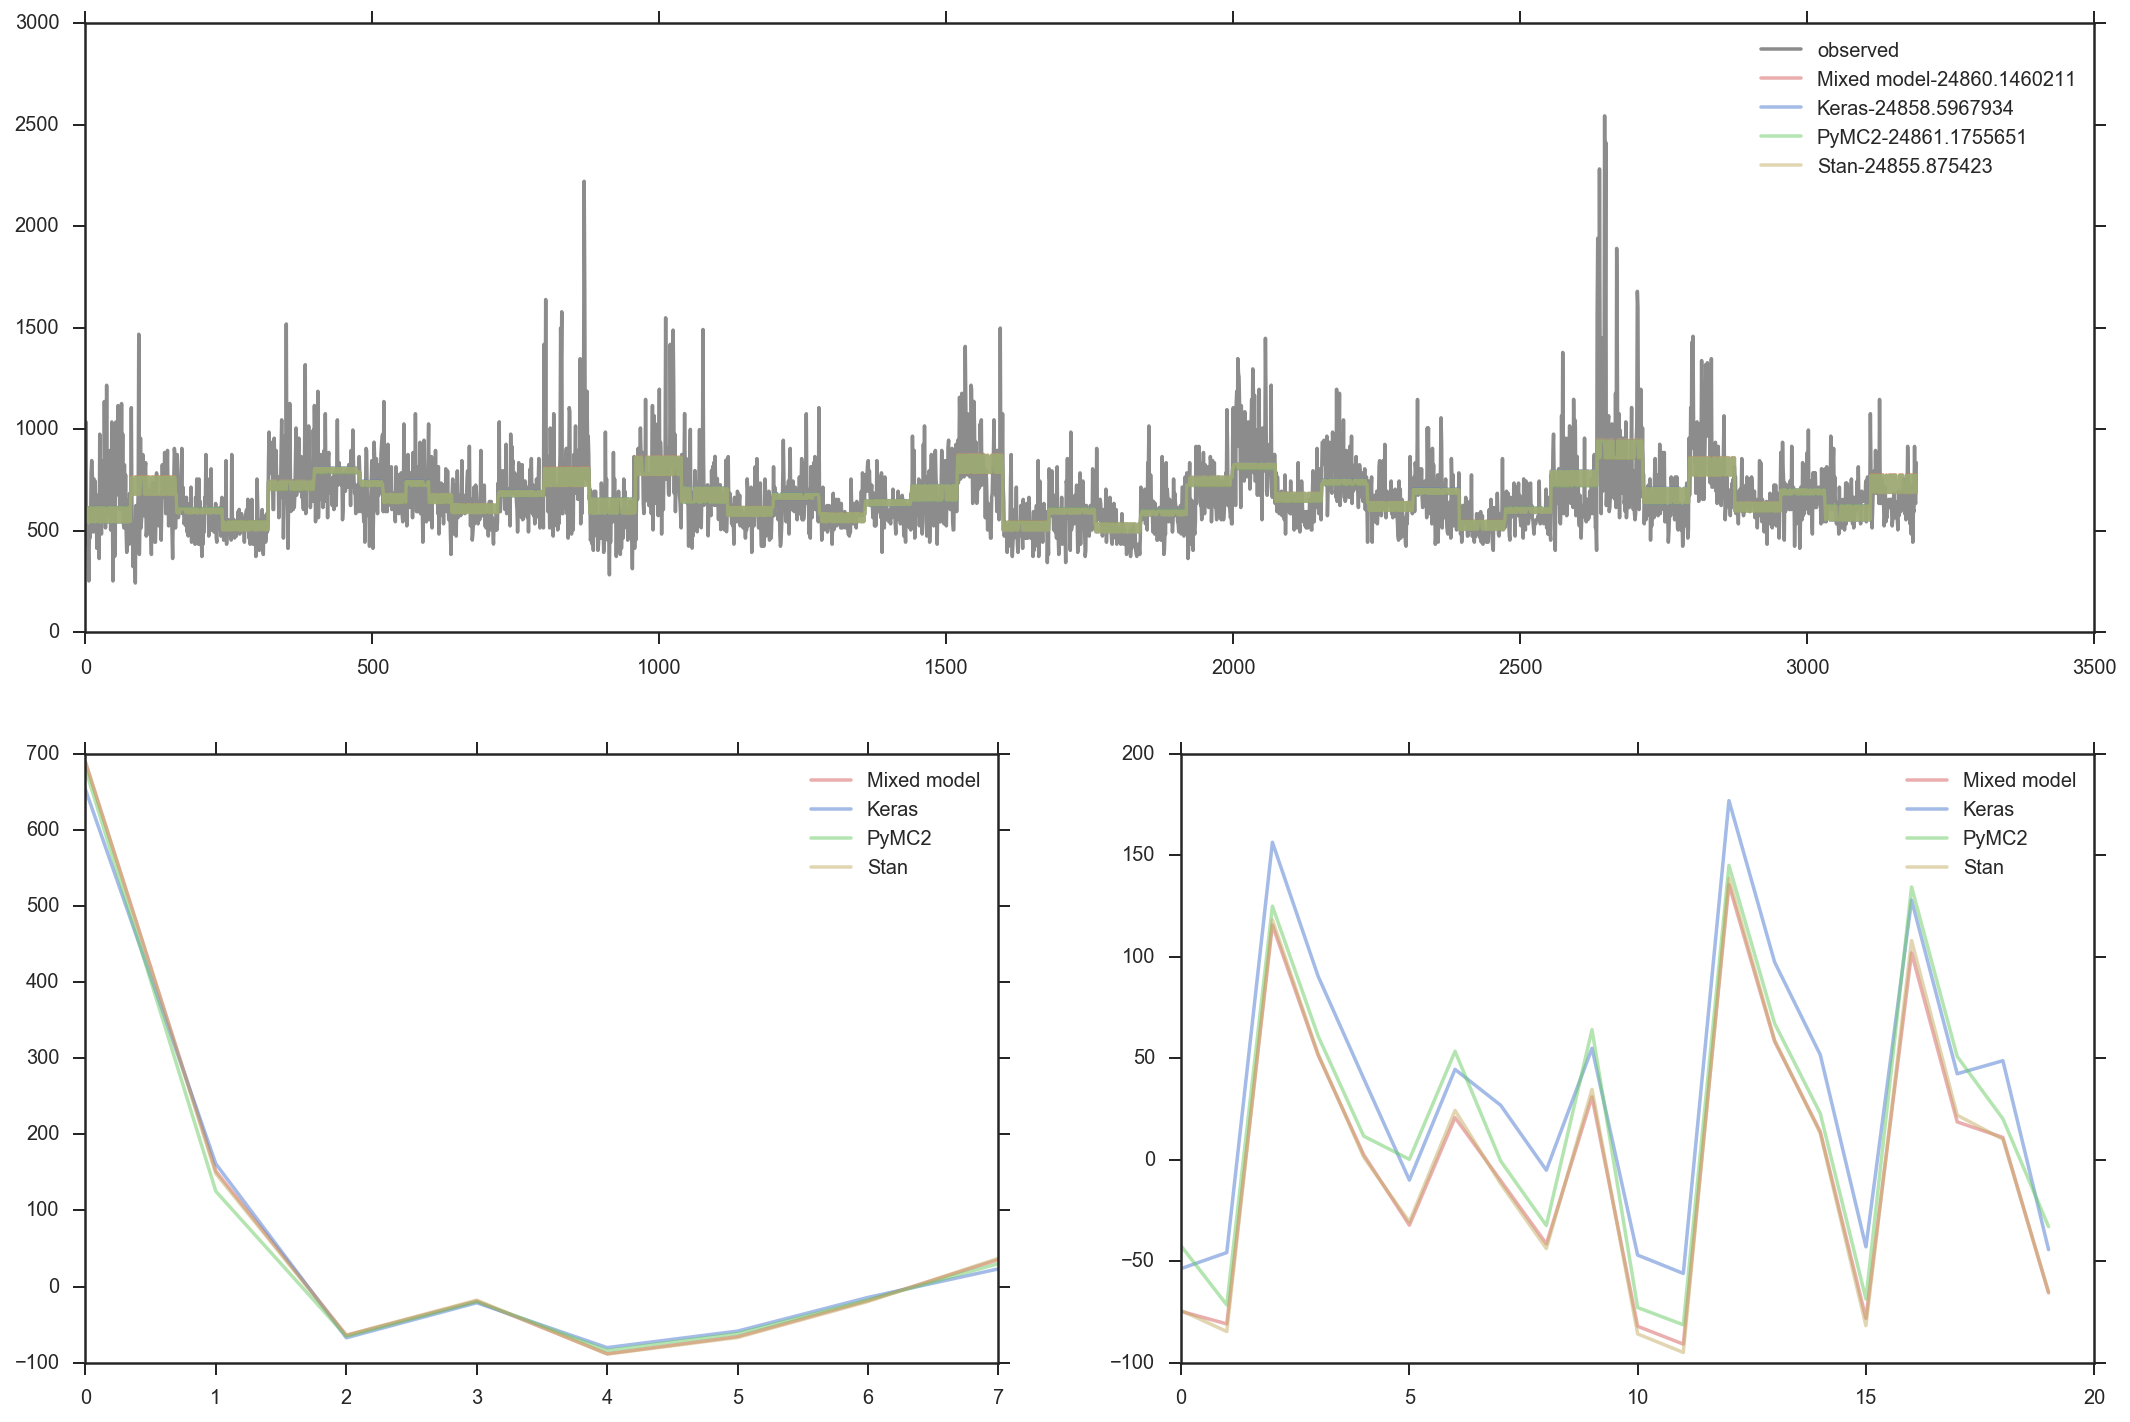

In [22]:
betakeras = np.hstack((model.get_weights()[1],model.get_weights()[0].flatten()))
bkeras = model.get_weights()[2]
fixedCoef2['Keras']  = pd.Series(betakeras,index=fixedCoef2.index)
print(fixedCoef2)

plt.figure(figsize=(18,12))
ax1 = plt.subplot(gs[0,0:2])
ax1.plot(yd,'k',alpha = .5)
ax1.plot(fitted,'r',alpha = .5)
fittedkeras=np.dot(X,betakeras).flatten()+np.dot(Z,bkeras).flatten()
ax1.plot(fittedkeras,'b',alpha = .5)
ax1.plot(fitted2,'g',alpha = .5)
ax1.plot(fittedstan,'y',alpha = .5)

ax1.legend(['observed',
            'Mixed model'+'-'+str(np.mean(np.square(yd-fitted))),
            'Keras'+'-'+str(np.mean(np.square(yd-fittedkeras))),
            'PyMC2'+'-'+str(np.mean(np.square(yd-fitted2))),
            'Stan'+'-'+str(np.mean(np.square(yd-fittedstan)))])

ax2 = plt.subplot(gs[1,0])
fixed=np.asarray(mdf.fe_params).flatten()
ax2.plot(fixed,'r',alpha = .5)
ax2.plot(betakeras,'b',alpha = .5)
ax2.plot(betapymc2,'g',alpha = .5)
ax2.plot(betastan,'y',alpha = .5)
ax2.legend(['Mixed model','Keras','PyMC2','Stan'])

ax3 = plt.subplot(gs[1,1])
randlmm=np.asarray(mdf.random_effects).flatten()
ax3.plot(randlmm,'r',alpha = .5)
ax3.plot(bkeras,'b',alpha = .5)
ax3.plot(bpymc2,'g',alpha = .5)
ax3.plot(bstan,'y',alpha = .5)
ax3.legend(['Mixed model','Keras','PyMC2','Stan'])
plt.show()